In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

In [ ]:
# === Load Train & test datasets === #
project = Path.cwd().parent
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")
test_df = pd.read_excel(target_folder / "test_clean.xlsx", sheet_name="Sheet1")

target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)
X_test = test_df.drop(columns=[target_col] + drop_cols)

# Convert target 'Yes'/'No' -> 1/0 (same as training)
y_train = train_df[target_col].map({"Yes": 1, "No": 0})
y_test = test_df[target_col].map({"Yes": 1, "No": 0})

if y_train.isna().any() or y_test.isna().any():
    raise ValueError("Target column contains values other than 'Yes'/'No'.")

In [ ]:
# === Load trained model === #
bundle = joblib.load(project / "4 - deployment/xgboost_model.pkl")

xg_base = bundle["base"]
xg_tuned = bundle["tuned"]

print("✅ XGBoost model loaded.")

✅ XGBoost model loaded.


In [ ]:
# === Get Cross-validation accuracy === #
scores = cross_val_score(xg_base, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation (Base Model) accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

scores = cross_val_score(xg_tuned, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation (Tuned Model) accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation (Base Model) accuracy: 0.8700 ± 0.0232
Cross-validation (Tuned Model) accuracy: 0.9375 ± 0.0209


In [ ]:
# === Predict on train/test (Base Model) === #
y_train_pred_base = xg_base.predict(X_train)
y_test_pred_base = xg_base.predict(X_test)

print("Training Accuracy (Base Model):", accuracy_score(y_train, y_train_pred_base))
print("Testing Accuracy (Base Model):", accuracy_score(y_test, y_test_pred_base))
print("\nConfusion Matrix (Base Model):\n", confusion_matrix(y_test, y_test_pred_base))
print("\nClassification Report (Base Model):\n", classification_report(y_test, y_test_pred_base))


Training Accuracy (Base Model): 0.94
Testing Accuracy (Base Model): 0.95

Confusion Matrix (Base Model):
 [[50  4]
 [ 1 45]]

Classification Report (Base Model):
               precision    recall  f1-score   support

           0       0.98      0.93      0.95        54
           1       0.92      0.98      0.95        46

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [ ]:
# === Predict on train/test (Tuned Model) === #
y_train_pred_tuned = xg_tuned.predict(X_train)
y_test_pred_tuned = xg_tuned.predict(X_test)

print("Training Accuracy (Tuned Model):", accuracy_score(y_train, y_train_pred_tuned))
print("Testing Accuracy (Tuned Model):", accuracy_score(y_test, y_test_pred_tuned))
print("\nConfusion Matrix (Tuned Model):\n", confusion_matrix(y_test, y_test_pred_tuned))
print("\nClassification Report (Tuned Model):\n", classification_report(y_test, y_test_pred_tuned))

Training Accuracy (Tuned Model): 0.9975
Testing Accuracy (Tuned Model): 0.98

Confusion Matrix (Tuned Model):
 [[52  2]
 [ 0 46]]

Classification Report (Tuned Model):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.96      1.00      0.98        46

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
# === Probabilities + Feasibility % (Base Model) === #
proba = xg_base.predict_proba(X_test)

# Find probability column for class 1 safely
classes = list(xg_base.classes_) if hasattr(xg_base, "classes_") else list(xg_base.named_steps["model"].classes_)
yes_index_base = classes.index(1) if 1 in classes else 1

feasibility_pct = np.round(proba[:, yes_index_base] * 100, 2)

results_base = X_test.copy()
results_base["Actual"] = np.where(y_test.values == 1, "Yes", "No")
results_base["Predicted"] = np.where(y_test_pred_base == 1, "Yes", "No")
results_base["Feasibility %"] = feasibility_pct
results_base["Model"] = "XGBoost (Base Model)"

results_base.head(10)

,Time Taken (mins),Complexity (1-5),Frequency,Tool Used,Department,Error Rate (%),Rule-Based Indicator,Process Stability,Data Structure,Actual,Predicted,Feasibility %,Model
0,0.380295,2,Quarterly,Trello,Customer Service,-1.058714,Yes,Medium,Semi-Structured,Yes,Yes,83.220001,XGBoost (Base Model)
1,-0.652825,2,Ad-Hoc,Slack,Procurement,-1.529068,Yes,Low,Unstructured,No,No,45.560001,XGBoost (Base Model)
2,0.896855,4,Monthly,Jira,Human Resource,-0.552179,No,Medium,Semi-Structured,Yes,Yes,81.209999,XGBoost (Base Model)
3,-1.418758,3,Quarterly,SAP,Compliance,-0.552179,Yes,Low,Unstructured,No,No,26.000000,XGBoost (Base Model)
4,-0.243139,2,Ad-Hoc,Google Sheets,IT,0.460891,No,Medium,Structured,No,No,10.190000,XGBoost (Base Model)
5,1.235290,5,Weekly,Slack,Sales,0.000608,No,Low,Unstructured,Yes,Yes,67.760002,XGBoost (Base Model)
6,0.647481,1,Monthly,Custom Portal,Compliance,0.641796,Yes,Medium,Semi-Structured,No,No,11.240000,XGBoost (Base Model)
7,0.540607,5,Ad-Hoc,Excel,IT,-0.190368,No,Medium,Structured,No,No,49.549999,XGBoost (Base Model)
8,-1.507820,2,Weekly,Google Sheets,IT,-0.262730,Yes,High,Structured,Yes,Yes,86.029999,XGBoost (Base Model)
9,0.326858,1,Quarterly,Jira,Admin,-1.203438,Yes,Medium,Semi-Structured,Yes,Yes,84.400002,XGBoost (Base Model)


ROC AUC (Base Model): 0.9903381642512077


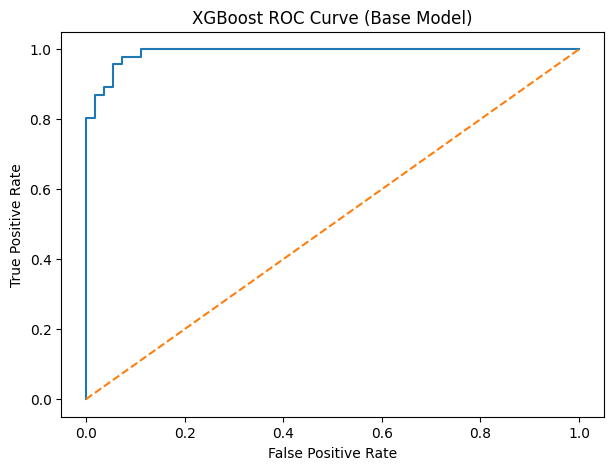

In [ ]:
# === ROC AUC + Curve (Base Model) === #
auc = roc_auc_score(y_test, proba[:, yes_index_base])
print("ROC AUC (Base Model):", auc)

fpr, tpr, _ = roc_curve(y_test, proba[:, yes_index_base])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve (Base Model)")
plt.show()

In [ ]:
# === Probabilities + Feasibility % (Tuned Model) === #
proba = xg_tuned.predict_proba(X_test)

# Find probability column for class 1 safely
classes = list(xg_tuned.classes_) if hasattr(xg_tuned, "classes_") else list(xg_tuned.named_steps["model"].classes_)
yes_index_tuned = classes.index(1) if 1 in classes else 1

feasibility_pct = np.round(proba[:, yes_index_tuned] * 100, 2)

results_tuned = X_test.copy()
results_tuned["Actual"] = np.where(y_test.values == 1, "Yes", "No")
results_tuned["Predicted"] = np.where(y_test_pred_tuned == 1, "Yes", "No")
results_tuned["Feasibility %"] = feasibility_pct
results_tuned["Model"] = "XGBoost (Tuned Model)"

results_tuned.head(10)

,Time Taken (mins),Complexity (1-5),Frequency,Tool Used,Department,Error Rate (%),Rule-Based Indicator,Process Stability,Data Structure,Actual,Predicted,Feasibility %,Model
0,0.380295,2,Quarterly,Trello,Customer Service,-1.058714,Yes,Medium,Semi-Structured,Yes,Yes,97.730003,XGBoost (Tuned Model)
1,-0.652825,2,Ad-Hoc,Slack,Procurement,-1.529068,Yes,Low,Unstructured,No,No,13.710000,XGBoost (Tuned Model)
2,0.896855,4,Monthly,Jira,Human Resource,-0.552179,No,Medium,Semi-Structured,Yes,Yes,97.760002,XGBoost (Tuned Model)
3,-1.418758,3,Quarterly,SAP,Compliance,-0.552179,Yes,Low,Unstructured,No,No,5.570000,XGBoost (Tuned Model)
4,-0.243139,2,Ad-Hoc,Google Sheets,IT,0.460891,No,Medium,Structured,No,No,0.130000,XGBoost (Tuned Model)
5,1.235290,5,Weekly,Slack,Sales,0.000608,No,Low,Unstructured,Yes,Yes,82.199997,XGBoost (Tuned Model)
6,0.647481,1,Monthly,Custom Portal,Compliance,0.641796,Yes,Medium,Semi-Structured,No,No,0.990000,XGBoost (Tuned Model)
7,0.540607,5,Ad-Hoc,Excel,IT,-0.190368,No,Medium,Structured,No,No,12.520000,XGBoost (Tuned Model)
8,-1.507820,2,Weekly,Google Sheets,IT,-0.262730,Yes,High,Structured,Yes,Yes,97.900002,XGBoost (Tuned Model)
9,0.326858,1,Quarterly,Jira,Admin,-1.203438,Yes,Medium,Semi-Structured,Yes,Yes,99.080002,XGBoost (Tuned Model)


ROC AUC (Tuned Model): 0.9943639291465379


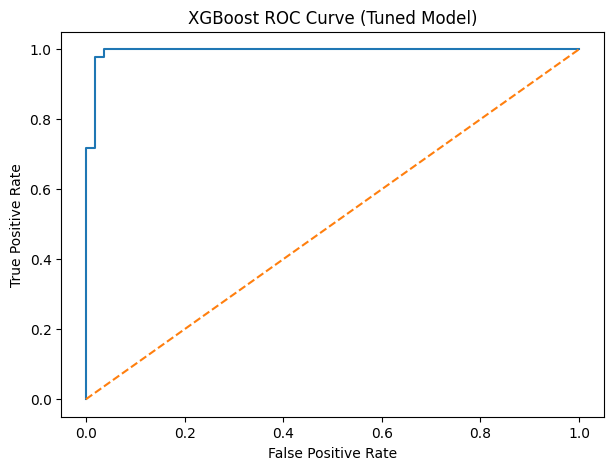

In [ ]:
# === ROC AUC + Curve (Tuned Model) === #
auc = roc_auc_score(y_test, proba[:, yes_index_tuned])
print("ROC AUC (Tuned Model):", auc)

fpr, tpr, _ = roc_curve(y_test, proba[:, yes_index_tuned])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve (Tuned Model)")
plt.show()

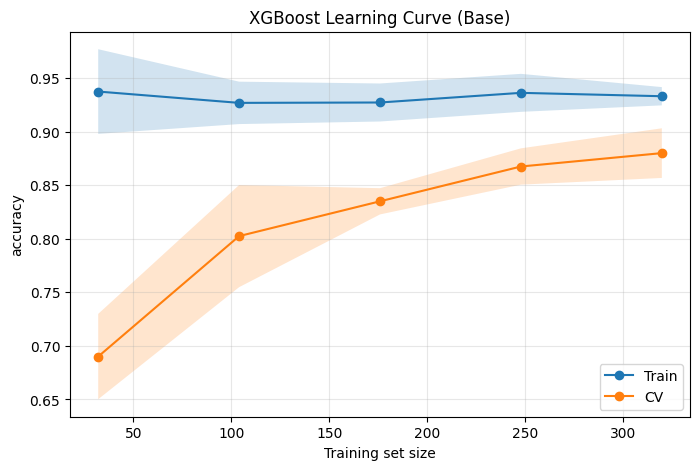

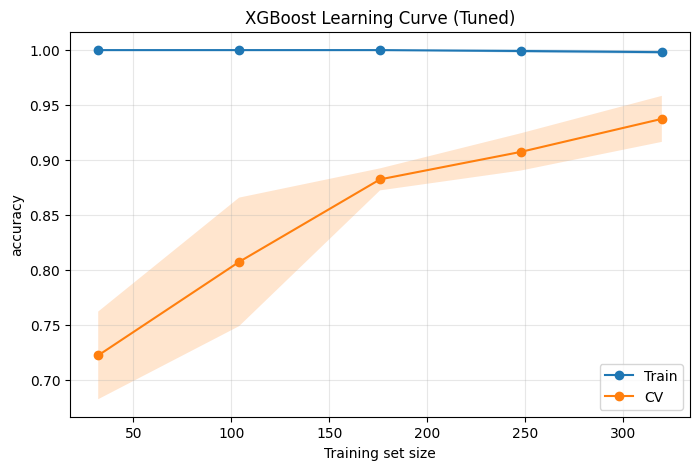

In [ ]:
# === Plot Learning Curve === #
def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning Curve",
    scoring="accuracy",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
):
    sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)

    val_mean = val_scores.mean(axis=1)
    val_std  = val_scores.std(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, train_mean, marker="o", label="Train")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(sizes, val_mean, marker="o", label="CV")
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel(scoring)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_learning_curve(
    estimator=xg_base,
    X=X_train,
    y=y_train,
    title="XGBoost Learning Curve (Base)",
    scoring="accuracy",
    cv=5
)

plot_learning_curve(
    estimator=xg_tuned,
    X=X_train,
    y=y_train,
    title="XGBoost Learning Curve (Tuned)",
    scoring="accuracy",
    cv=5
)


       Original Feature  Importance            Model
0             Tool Used    0.475377  XGBoost (Tuned)
1     Process Stability    0.145455  XGBoost (Tuned)
2            Department    0.110566  XGBoost (Tuned)
3             Frequency    0.086339  XGBoost (Tuned)
4        Data Structure    0.070074  XGBoost (Tuned)
5  Rule-Based Indicator    0.047904  XGBoost (Tuned)
6        Error Rate (%)    0.034454  XGBoost (Tuned)
7     Time Taken (mins)    0.021613  XGBoost (Tuned)
8      Complexity (1-5)    0.008218  XGBoost (Tuned)


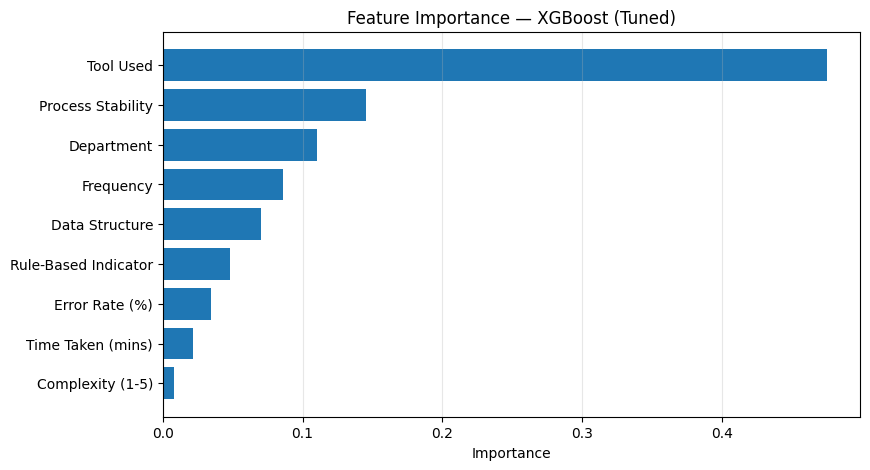

In [ ]:
# === Plot Feature Importance === #
def get_feature_importance_df(
    pipeline,
    top_n: int = 10,
    model_label: str = "Model"
) -> pd.DataFrame:
    if not hasattr(pipeline.named_steps["model"], "feature_importances_"):
        raise ValueError("This model does not support feature_importances_ (not tree-based).")

    preprocess = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]

    # --- Get categorical + numeric column lists from ColumnTransformer
    cat_cols = preprocess.transformers_[0][2]
    num_cols = preprocess.transformers_[1][2]

    ohe = preprocess.transformers_[0][1]
    ohe_names = ohe.get_feature_names_out(cat_cols)
    all_feature_names = list(ohe_names) + list(num_cols)

    importances = model.feature_importances_

    fi = pd.DataFrame({
        "Encoded Feature": all_feature_names,
        "Importance": importances
    })

    # Aggregate one-hot features back to original feature name
    fi["Original Feature"] = fi["Encoded Feature"].apply(lambda x: x.split("_")[0])

    agg = (
        fi.groupby("Original Feature", as_index=False)["Importance"]
          .sum()
          .sort_values("Importance", ascending=False)
          .head(top_n)
          .reset_index(drop=True)
    )

    agg["Model"] = model_label
    return agg

def plot_feature_importance(fi_df: pd.DataFrame, title: str):
    plt.figure(figsize=(9, 5))
    plt.barh(fi_df["Original Feature"][::-1], fi_df["Importance"][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.grid(True, axis="x", alpha=0.3)
    plt.show()

fi_tuned = get_feature_importance_df(xg_tuned, top_n=10, model_label="XGBoost (Tuned)")
print(fi_tuned)
plot_feature_importance(fi_tuned, "Feature Importance — XGBoost (Tuned)")

In [ ]:
# === Save prediction results to CSV (Base & Tuned set) === #
export_path_base = project / "3 - evaluation/xgboost_base_model_summary.csv"
results_to_save_base = results_base.copy()
results_to_save_base["Model"] = "XGBoost (Base Model)"
results_to_save_base.to_csv(export_path_base, index=False)
print(f"✅ Prediction summary saved to: {export_path_base}")

export_path_tuned = project / "3 - evaluation/xgboost_tuned_model_summary.csv"
results_to_save_tuned = results_tuned.copy()
results_to_save_tuned["Model"] = "XGBoost (Tuned Model)"
results_to_save_tuned.to_csv(export_path_tuned, index=False)
print(f"✅ Prediction summary saved to: {export_path_tuned}")

✅ Prediction summary saved to: c:\Users\victo\Desktop\project\3 - evaluation\xgboost_base_model_summary.csv
✅ Prediction summary saved to: c:\Users\victo\Desktop\project\3 - evaluation\xgboost_tuned_model_summary.csv
